In [1]:
import os 
import sys
import ast
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import fbprophet as pro

%matplotlib inline

# Importing data

## Pageview and revisions

In [2]:
combined_data = pd.read_csv('../data/test15/cleaned/combined.csv')
combined_data.timestamp = pd.to_datetime(combined_data.timestamp)
# In the interest of memory I'm going to immeadiately subset the combined data
combined_data = combined_data[['timestamp', 'revid', 'page_title', 'character_count', 
                               'external_link_count', 'heading_count', 'page_views',
                               'wikifile_count', 'wikilink_count', 'word_count']]

# combined_data = combined_data.reset_index()
# combined_data = combined_data.set_index(['page_title', 'timestamp'])

In [3]:
combined_data.sort_values(by=['page_title', 'timestamp'], inplace=True)

In [4]:
combined_data.head()

,timestamp,revid,page_title,character_count,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
0,2015-07-01,NaN,'Amran,NaN,NaN,NaN,14.0,NaN,NaN,NaN
1,2015-07-02,NaN,'Amran,NaN,NaN,NaN,12.0,NaN,NaN,NaN
2,2015-07-03,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN
3,2015-07-04,NaN,'Amran,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,2015-07-05,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN


## Category data

In [5]:
category_data = pd.read_csv('../data/test15/cleaned/category_data.csv')

In [6]:
category_data.head()

,Unnamed: 0,page_title,revid,categories
0,0,Aubre de Lambert Maynard,786130355.0,[]
1,1,Nabla,715468992.0,[]
2,2,President-elect of the United States,670644904.0,"['Titles', 'Elections in the United States']"
3,3,Space Oddity,672181778.0,"['1975 singles', 'Song recordings produced by ..."
4,4,Tillakaratne Dilshan,669932370.0,"['Sri Lankan Buddhists', 'People from Western ..."


## Links pointing to pages

In [7]:
pointer_data = pd.read_csv('../data/test15/cleaned/pointers.csv')

In [8]:
pointer_data.head()

,Unnamed: 0,page_title,talk_link_count,wiki_link_count,wikipeida_count,user_count
0,15,'Amran,1,68,0,0
1,16,'Amran Governorate,1,103,0,0
2,17,'Asir Region,9,97,0,0
3,19,'Hours...',10,7,0,0
4,20,+1 button,0,2,0,0


# Identifying important categories

In [9]:
category_dict = {}
# category_data.set_index('page_title', inplace=True)

for page_title, df in category_data.iterrows():
    # lists were converted to a single string parsing them with ast
    for category in ast.literal_eval(df['categories']):
        try:
            category_dict[category] += 1
        except:
            category_dict[category] = 1


In [10]:
category_df = pd.DataFrame.from_dict(category_dict, orient='index')

In [11]:
category_df = category_df.sort_values(by=0, ascending=False)

In [12]:
category_df.iloc[:50]

,0
Living people,957
Articles containing video clips,195
American people of Irish descent,101
American people of English descent,100
Grammy Award winners,99
21st-century American writers,79
Battles of World War I involving Germany,78
World Digital Library related,77
20th-century American writers,75
American people of German descent,73


In [13]:
# subsetting a selection of categories

list_of_categories = ['Living people', 'Grammy Award winners', 
                      '21st-century American writers', '20th-century American writers',
                      'Member states of the United Nations', 'American films',
                      'American political writers', 'Machine learning']

In [43]:
# Pulling out the page titles which have these pages

category_dict = {}
category_data.set_index('page_title', inplace=True)

for page, df in category_data.iterrows():
    for category in ast.literal_eval(df['categories']):
        if category in list_of_categories:
            try:
                category_dict[category].append(page)
            except:
                category_dict[category] = [page]

# Determing wikipedia revision summary data

Instead of knowing specific details of each edit it would be nice to know the number of edits that wikipedia page experinced in a single day

In [199]:
# Generating summary numbers for edits

# combined_data.set_index('timestamp', inplace=True)
number_of_edits = combined_data[['revid', 'page_title']].groupby('page_title')['revid'].resample('1d').count()
number_of_edits = number_of_edits.to_frame(name='number_of_edits')

In [200]:
number_of_edits.reset_index(inplace=True)

In [201]:
number_of_edits.set_index(['page_title', 'timestamp'], inplace=True)

In [202]:
combined_data.reset_index(inplace=True)
combined_data.set_index(['page_title', 'timestamp'],inplace=True)

In [203]:
combined_data = pd.concat([combined_data, number_of_edits], sort=False)

In [204]:
combined_data = combined_data.sort_index(level=1).sort_index(level=0)

In [205]:
# Resampling to deal with difficulties in aligning data

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
combined_data = combined_data.groupby('page_title').resample('1d').mean()

# Data analysis 

## Forcasting activity on Wikipedia with all data

### Page veiws

In [100]:
combined_data.reset_index(inplace=True)
resampled_data = combined_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

In [101]:
resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [102]:
m = pro.Prophet()
m.fit(resampled_data);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [103]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

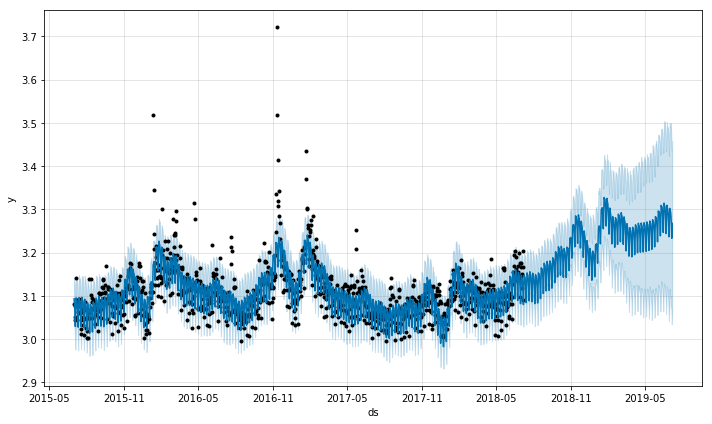

In [104]:
fig1 = m.plot(forecast)

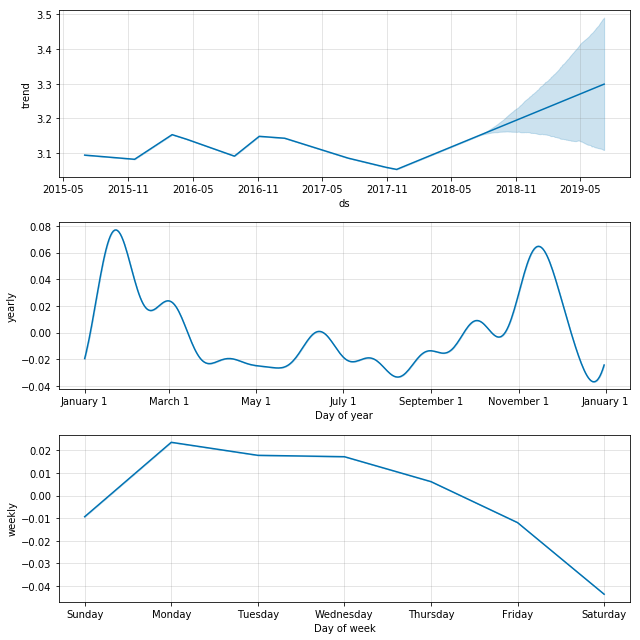

In [105]:
fig2 = m.plot_components(forecast)

### Edit frequency

In [28]:
resampled_data = combined_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

In [106]:
resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [30]:
m = pro.Prophet()
m.fit(resampled_data);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [31]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

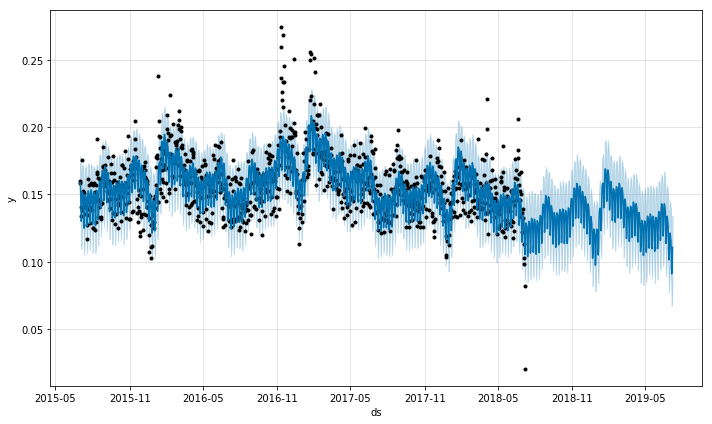

In [32]:
fig1 = m.plot(forecast)

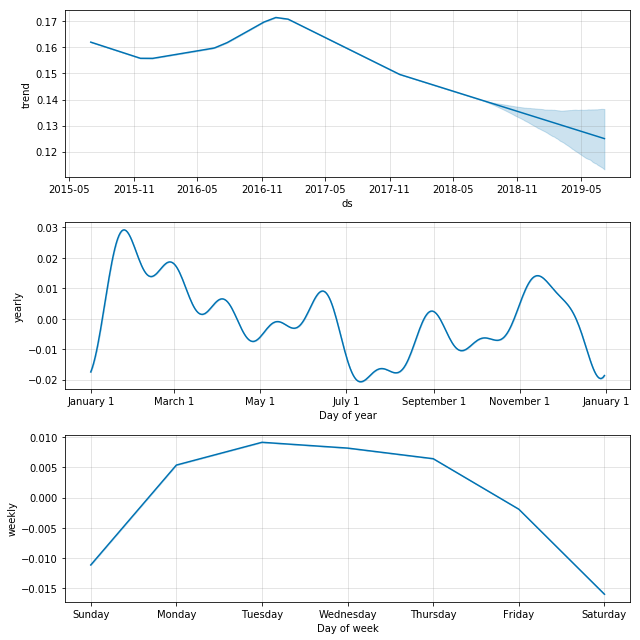

In [33]:
fig2 = m.plot_components(forecast)

It is important to note that weekly trends for both edits and pageviews follow the same trend of being dominantly carried out between Monday and Thursday of the week. This is counter to what I expected as I assumed people would take the time to edit wikipeida when they have excessive free time on the weekends. That said this analysis does not consider the types of edits that are carried out. It is possible that "major edits" or edits that would require a significant amount of time to implement would take place during weekends. 

## Forcasting activity of wikipedia of articles about people or not about people

### Pages about people (pageviews)

In [107]:
pages_about_people = category_dict['Living people']

In [109]:
combined_data.reset_index(inplace=True)
resampled_data = combined_data[combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [110]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


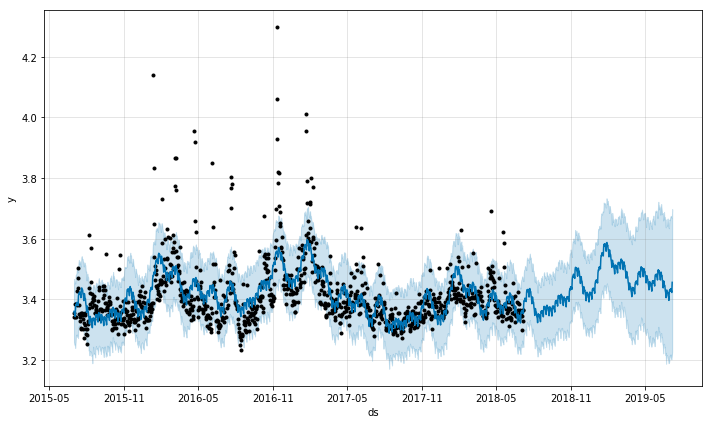

In [111]:
fig1 = m.plot(forecast)

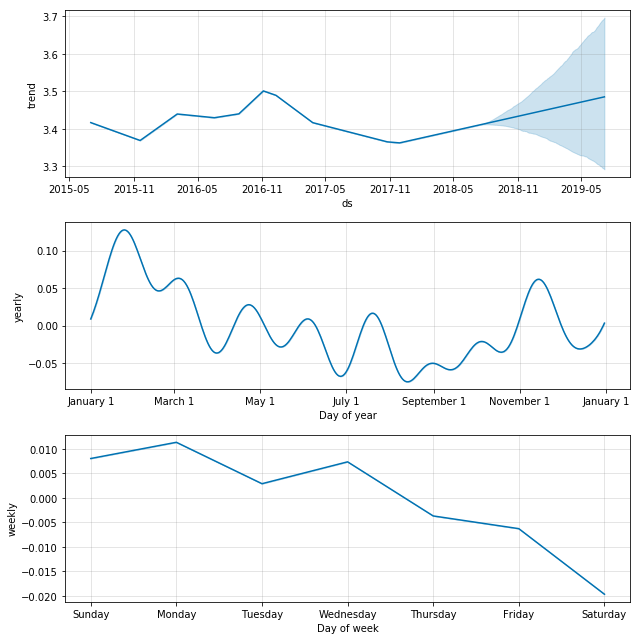

In [112]:
fig2 = m.plot_components(forecast)

### Pages about people (edit frequency)

In [113]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [114]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


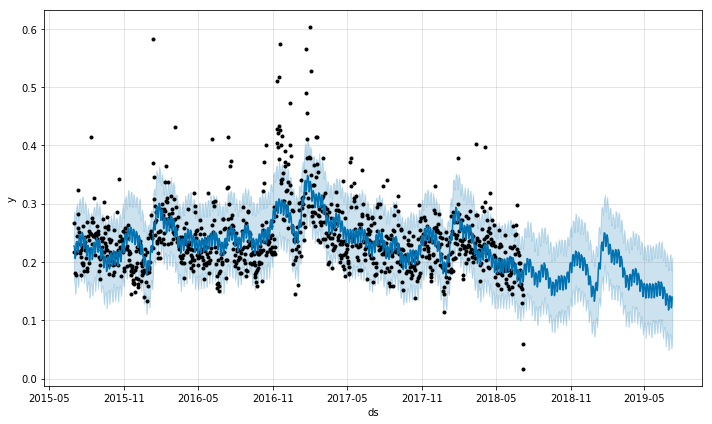

In [115]:
fig1 = m.plot(forecast)

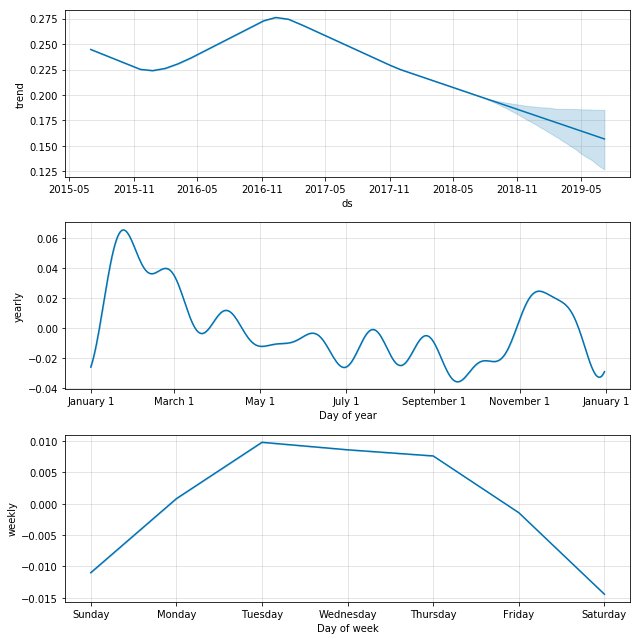

In [116]:
fig2 = m.plot_components(forecast)

### Pages not about people (page views)

In [117]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[-combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [118]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


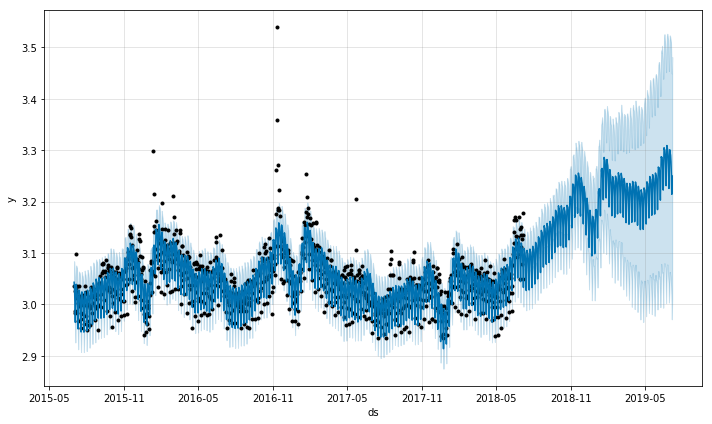

In [119]:
fig1 = m.plot(forecast)

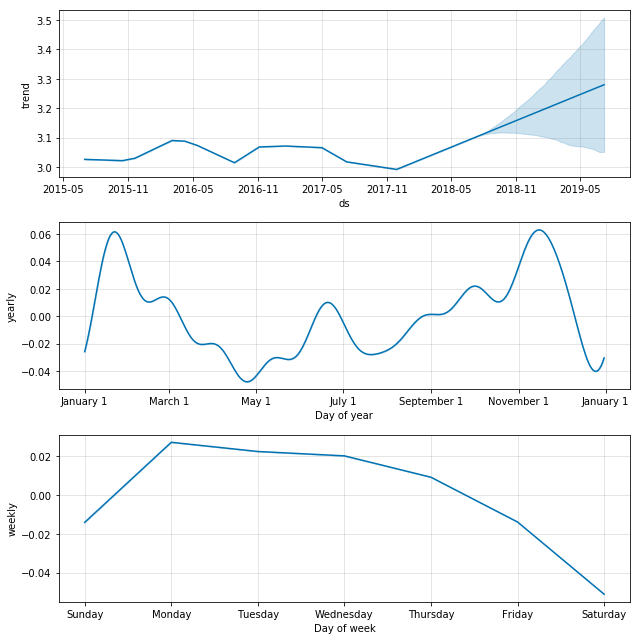

In [120]:
fig2 = m.plot_components(forecast)

### Pages not about people (Edit frequency)

In [121]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[-combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [122]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


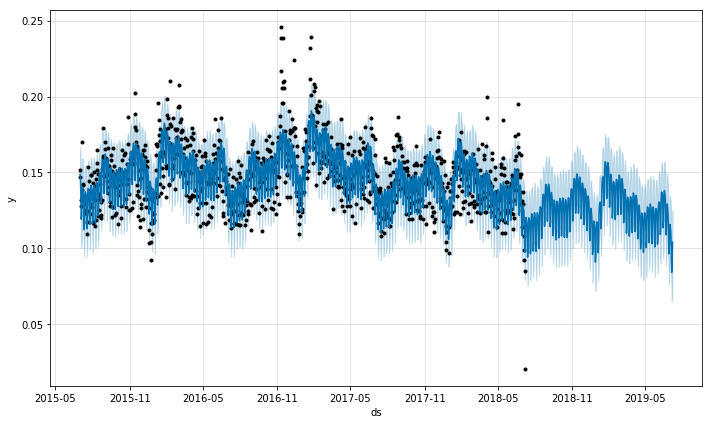

In [123]:
fig1 = m.plot(forecast)

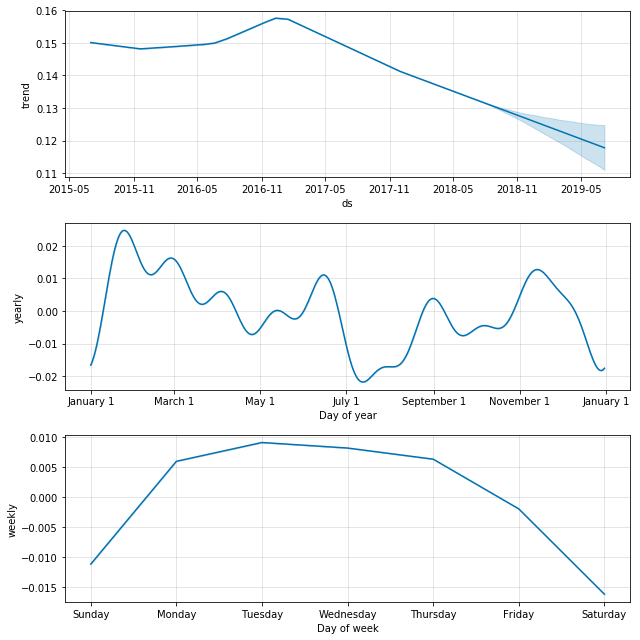

In [124]:
fig2 = m.plot_components(forecast)

In [3]:
# Resampling combined_pageview data to single datas to find average characteristics

combined_data.set_index('timestamp', inplace=True)
resampled_data = combined_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('1d').mean()

resampled_data.reset_index(inplace=True)

# # Further normalizing this data to a week

# resampled_data.set_index('timestamp', inplace=True)
# resampled_data = resampled_data[['page_title', 'character_count', 'external_link_count',
#                    'heading_count', 'page_views',
#                    'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').mean()

# resampled_data.reset_index(inplace=True)

# resampled_data.set_index('timestamp')
# resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())

## Regression analysis

### What correlates to a pages popularity


In [206]:
combined_data

level_0      index  revid  character_count  \
page_title timestamp                                                  
'Amran     2015-07-01        0.0        0.0    NaN              NaN   
           2015-07-02        1.0        1.0    NaN              NaN   
           2015-07-03        2.0        2.0    NaN              NaN   
           2015-07-04        3.0        3.0    NaN              NaN   
           2015-07-05        4.0        4.0    NaN              NaN   
           2015-07-06        5.0        5.0    NaN              NaN   
           2015-07-07        6.0        6.0    NaN              NaN   
           2015-07-08        7.0        7.0    NaN              NaN   
           2015-07-09        8.0        8.0    NaN              NaN   
           2015-07-10        9.0        9.0    NaN              NaN   
           2015-07-11       10.0       10.0    NaN              NaN   
           2015-07-12       11.0       11.0    NaN              NaN   
           2015-07-13       12.0       12.0    NaN              NaN   
           2015-07-14       13.0       13.0    NaN              NaN   
           2015-07-15       14.0       14.0    NaN              NaN   
           2015-07-16       15.0       15.0    NaN              NaN   
           2015-07-17       16.0       16.0    NaN              NaN   
           2015-07-18       17.0       17.0    NaN              NaN   
           2015-07-19       18.0       18.0    NaN              NaN   
           2015-07-20       19.0       19.0    NaN              NaN   
           2015-07-21       20.0       20.0    NaN              NaN   
           2015-07-22       21.0       21.0    NaN              NaN   
           2015-07-23       22.0       22.0    NaN              NaN   
           2015-07-24       23.0       23.0    NaN              NaN   
           2015-07-25       24.0       24.0    NaN              NaN   
           2015-07-26       25.0       25.0    NaN              NaN   
           2015-07-27       26.0       26.0    NaN              NaN   
           2015-07-28       27.0       27.0    NaN              NaN   
           2015-07-29       28.0       28.0    NaN              NaN   
           2015-07-30       29.0       29.0    NaN              NaN   
...                          ...        ...    ...              ...   
Āryāvarta  2018-06-09  9629058.0  9629058.0    NaN              NaN   
           2018-06-10  9629059.0  9629059.0    NaN              NaN   
           2018-06-11  9629060.0  9629060.0    NaN              NaN   
           2018-06-12  9629061.0  9629061.0    NaN              NaN   
           2018-06-13  9629062.0  9629062.0    NaN              NaN   
           2018-06-14  9629063.0  9629063.0    NaN              NaN   
           2018-06-15  9629064.0  9629064.0    NaN              NaN   
           2018-06-16  9629065.0  9629065.0    NaN              NaN   
           2018-06-17  9629066.0  9629066.0    NaN              NaN   
           2018-06-18  9629067.0  9629067.0    NaN              NaN   
           2018-06-19  9629068.0  9629068.0    NaN              NaN   
           2018-06-20  9629069.0  9629069.0    NaN              NaN   
           2018-06-21  9629070.0  9629070.0    NaN              NaN   
           2018-06-22  9629071.0  9629071.0    NaN              NaN   
           2018-06-23  9629072.0  9629072.0    NaN              NaN   
           2018-06-24  9629073.0  9629073.0    NaN              NaN   
           2018-06-25  9629074.0  9629074.0    NaN              NaN   
           2018-06-26  9629075.0  9629075.0    NaN              NaN   
           2018-06-27  9629076.0  9629076.0    NaN              NaN   
           2018-06-28  9629077.0  9629077.0    NaN              NaN   
           2018-06-29  9629078.0  9629078.0    NaN              NaN   
           2018-06-30  9629079.0  9629079.0    NaN              NaN   
           2018-07-01  9629080.0  9629080.0    NaN              NaN   
           2018-07-02  9629081.0  9629081.0    Na

In [212]:
# let's resample this data by years taking the average

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
resampled_data = combined_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 'word_count', 'number_of_edits']].groupby('page_title').resample('1d').mean()

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp')
resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)

resampled_data = resampled_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 
                                 'word_count', 'number_of_edits']].groupby('page_title').resample('1y').mean()

resampled_data.reset_index(inplace=True)

In [213]:
resampled_data = resampled_data.dropna()

First we'll look at the distributions of important variables

In [214]:
resampled_data = resampled_data[(resampled_data.page_views > 0) & 
                                (resampled_data.word_count > 0)]

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


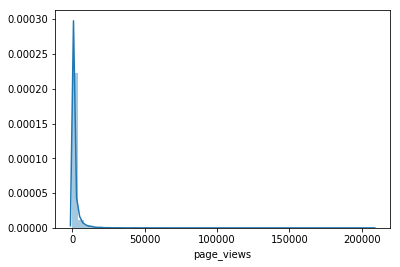

In [215]:
sns.distplot(resampled_data.page_views);

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


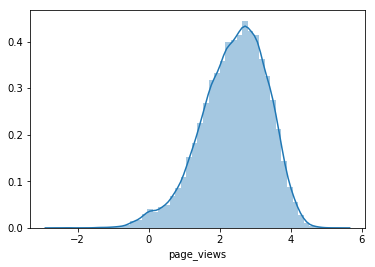

In [216]:
sns.distplot(np.log10(resampled_data.page_views));

In [217]:
# Pageviews are skewed so we'll take the log 

resampled_data['log10_page_views'] = np.log10(resampled_data.page_views)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


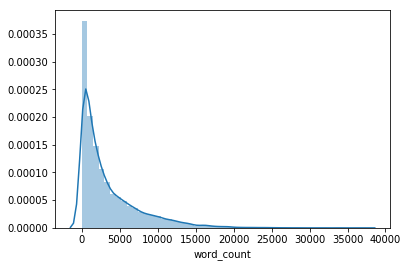

In [218]:
sns.distplot(resampled_data.word_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


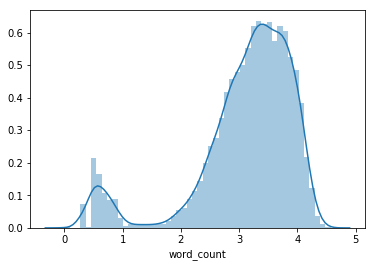

In [219]:
sns.distplot(np.log10(resampled_data.word_count))

It appears that articles with wordcoutns less than 10^3 outliers from the more gaussain response 

In [220]:
resampled_data = resampled_data[resampled_data.word_count > 10**2]

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


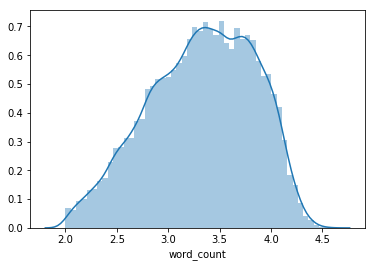

In [221]:
sns.distplot(np.log10(resampled_data.word_count))

In [222]:
resampled_data['log10_word_count'] = np.log10(resampled_data.word_count)

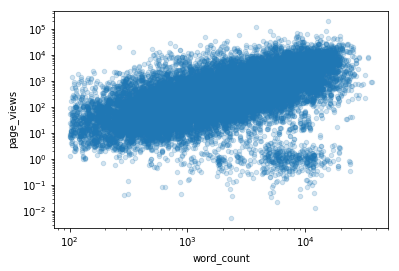

In [223]:
resampled_data.plot(x='word_count', y='page_views', loglog=True, kind='scatter', alpha=0.2)

What is that lower population?

In [224]:
resampled_data[(resampled_data.page_views < 100) & (resampled_data.word_count > 2000)].page_title.unique()

array(['1968 Washington, D.C. riots', '2003 Afro-Asian Games',
       '2012 Republican National Convention',
       '52nd (Lowland) Infantry Division',
       '55th (West Lancashire) Infantry Division',
       '58th Primetime Emmy Awards', 'A Reality Tour',
       'ANZAC Mounted Division', 'Adversarial machine learning',
       'Albany Movement', 'Albert Ernest Kitson', 'Alex Jones',
       'Algebraic number theory', 'Allan Nevins', 'Allard K. Lowenstein',
       'Ameen Rihani', 'American Friends Service Committee',
       'American Jewish Committee', 'Andrews Air Force Base',
       'Andrey Korotayev', 'Anisfield-Wolf Book Award', 'Ante Starčević',
       'Apollonius of Rhodes', 'Applied Biosystems', 'ArtRave',
       'Artists with the most number-ones on the U.S. Dance Club Songs chart',
       'Atlanta in the American Civil War', 'Aura (song)',
       'Australian Centre for the Moving Image', 'Australian Light Horse',
       "Bahá'í Faith in India", 'Balkan League', 'Baltimore riot 

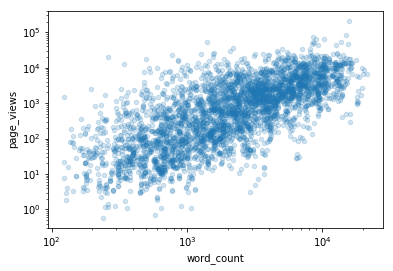

In [225]:
resampled_data[resampled_data.page_title.isin(pages_about_people)].plot(x='word_count', y='page_views', loglog=True, kind='scatter', alpha=0.2)


c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


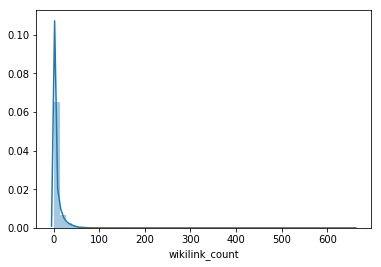

In [226]:
sns.distplot(resampled_data.wikilink_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


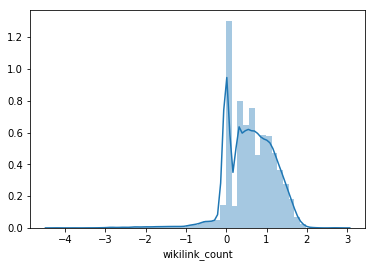

In [227]:
sns.distplot(np.log10(resampled_data[resampled_data.wikilink_count >0].wikilink_count))

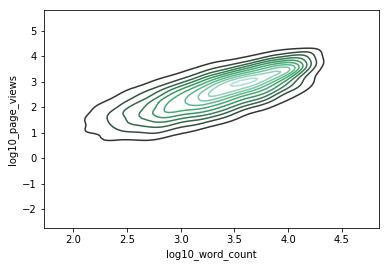

In [228]:
sns.kdeplot(data=resampled_data.log10_word_count, data2=resampled_data.log10_page_views)

# Using a regression model to infer important parameters

In [229]:
from sklearn import model_selection

In [230]:
train, test = model_selection.train_test_split(resampled_data.page_title.unique(), test_size=0.2)

train_data = resampled_data[resampled_data.page_title.isin(train)]
test_data = resampled_data[resampled_data.page_title.isin(test)]

In [231]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['external_link_count',
                         'heading_count', 'wikifile_count', 'wikilink_count',
                         'log10_word_count']], 
        y=train_data[['log10_page_views']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [232]:
prediction = reg.predict(test_data[['external_link_count', 'heading_count', 'wikifile_count', 'wikilink_count',
                                    'log10_word_count']])

In [233]:
print('Coefficients: \n', reg.coef_)

Coefficients: 
 [[ 1.58599925e-03 -4.56481374e-03  4.66393489e-04 -6.57157975e-06
   7.94819052e-01]]


In [234]:
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))

Mean squared error: 0.51


In [235]:
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Variance score: 0.35


In [236]:
resampled_data['pageview_prediction'] = reg.predict(resampled_data[['external_link_count',
                                 'heading_count', 'wikifile_count', 'wikilink_count',
                                     'log10_word_count']])

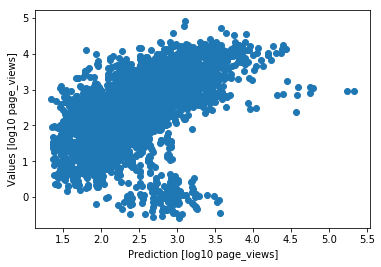

In [237]:
fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Values [log10 page_views]');

In [238]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count']], 
        y=train_data[['log10_page_views']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [239]:
prediction = reg.predict(test_data[['log10_word_count']])

In [240]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Coefficients: 
 [[0.97385376]]
Mean squared error: 0.54
Variance score: 0.31


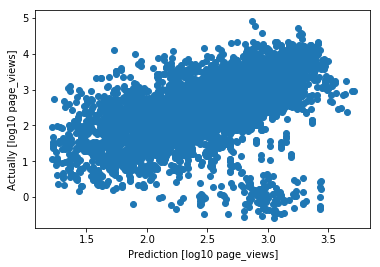

In [241]:
fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

In [242]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count', 'wikifile_count', 'wikilink_count']], 
        y=train_data[['log10_page_views']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [243]:
prediction = reg.predict(test_data[['log10_word_count', 'wikifile_count', 'wikilink_count']])

In [244]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Coefficients: 
 [[7.94264249e-01 6.30214979e-04 1.00153575e-03]]
Mean squared error: 0.52
Variance score: 0.33


In [256]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count', 'wikifile_count', 'number_of_edits']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count', 'wikifile_count', 'number_of_edits']])

In [257]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Coefficients: 
 [[6.48170631e-01 7.48528489e-05 1.54112591e+00]]
Mean squared error: 0.47
Variance score: 0.39


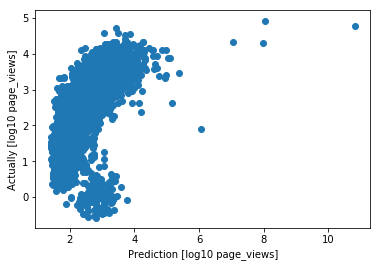

In [258]:
fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

In summary of this anaylysis, the size of a page determines roughly 50% of the observed varience of our data when fit to a linear mondel. The inclusion of wikilinks and wikfiles marginally improves the explination of varience. 

I now wonder what causes these websites to grow? Was it a nascient popularity that encouraged users to edit the pages or something else. 

In [252]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_page_views']], 
        y=train_data[['number_of_edits']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [253]:
prediction = reg.predict(test_data[['log10_page_views']])

In [254]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.number_of_edits, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Coefficients: 
 [[0.13070288]]
Mean squared error: 0.03
Variance score: -6.82


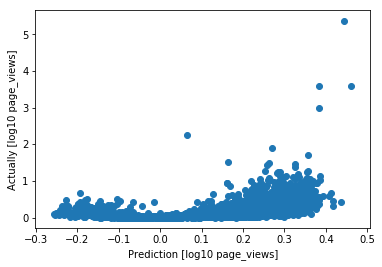

In [255]:
fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.number_of_edits))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

# Individual performance

There is only pointer data for the most current version of a page. Let's confirm that these trends hold for the just the most current data set

In [175]:
resampled_data.set_index('timestamp', inplace=True)

In [176]:
resampled_data_current_stats = resampled_data.loc['2018-12-31']

In [177]:
pages = set(resampled_data_current_stats.page_title) & set(pointer_data.page_title)

In [178]:
resampled_data_current_stats = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(pages)]

In [179]:
train, test = model_selection.train_test_split(resampled_data_current_stats.page_title.unique(), test_size=0.2)

train_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(train)]
test_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(test)]

Coefficients: 
 [[0.98246416]]
Mean squared error: 0.53
Variance score: 0.33


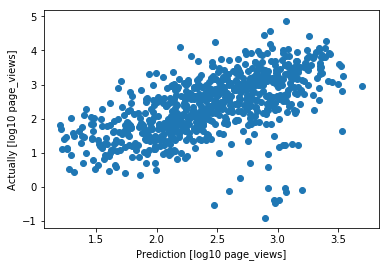

In [180]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count']])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

The trend holds

In [181]:
len(set(resampled_data_current_stats.page_title) & set(pointer_data.page_title))

3753

In [182]:
# Subsetting the pointer data to only include shared pages

pointer_data = pointer_data[pointer_data.page_title.isin(pages)]
pointer_data.set_index('page_title', inplace=True)

In [183]:
resampled_data_current_stats.reset_index(inplace=True)
resampled_data_current_stats.set_index(['page_title'], inplace=True)

In [184]:
resampled_data_current_stats = pd.concat([pointer_data, resampled_data_current_stats], axis=1)

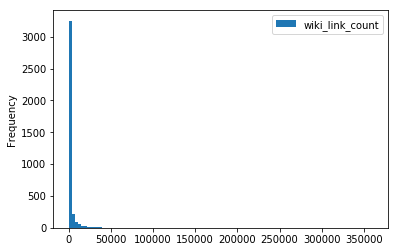

In [186]:
resampled_data_current_stats.plot(y=['wiki_link_count'], kind='hist', bins=100)

This appears skewed 

In [187]:
resampled_data_current_stats['log_wiki_link_count'] = np.log10(resampled_data_current_stats.wiki_link_count)

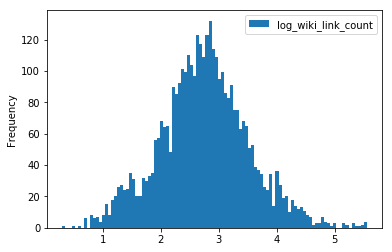

In [188]:
resampled_data_current_stats.plot(y=['log_wiki_link_count'], kind='hist', bins=100)

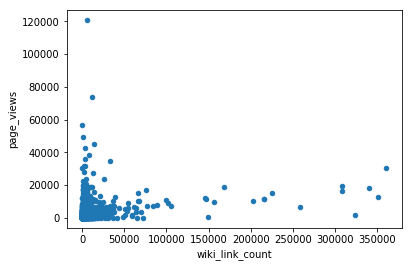

In [189]:
resampled_data_current_stats.plot(x='wiki_link_count', y='page_views', kind='scatter')

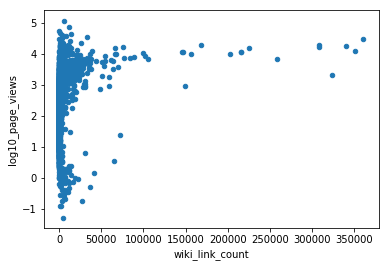

In [190]:
resampled_data_current_stats.plot(x='wiki_link_count', y='log10_page_views', kind='scatter')

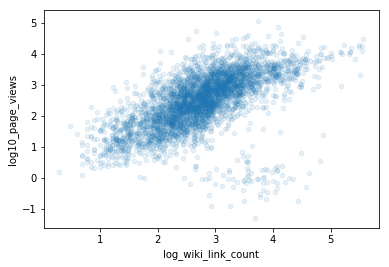

In [192]:
resampled_data_current_stats.plot(x='log_wiki_link_count', y='log10_page_views', kind='scatter', alpha=0.1)

In [193]:
resampled_data_current_stats.reset_index(inplace=True)

train, test = model_selection.train_test_split(resampled_data_current_stats.page_title.unique(), test_size=0.2)

train_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(train)]
test_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(test)]

Coefficients: 
 [[0.58169158 0.43207728]]
Mean squared error: 0.48
Variance score: 0.39


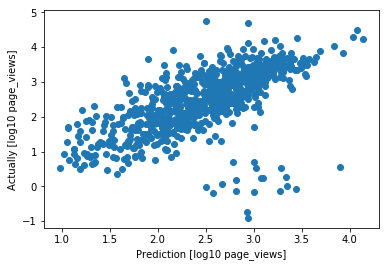

In [194]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count', 'log_wiki_link_count']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count', 'log_wiki_link_count']])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

Coefficients: 
 [[0.99363848]]
Mean squared error: 0.54
Variance score: 0.31


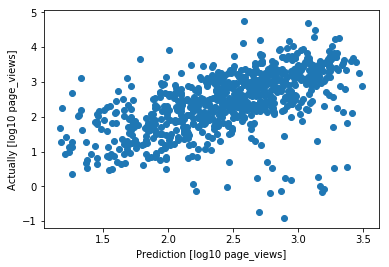

In [195]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count']])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

Coefficients: 
 [[-2.32261431e-03 -5.15278371e-05  4.79183735e-01  1.43241446e-03
   4.27857130e-01 -1.40450353e-05  0.00000000e+00]]
Mean squared error: 0.47
Variance score: 0.40


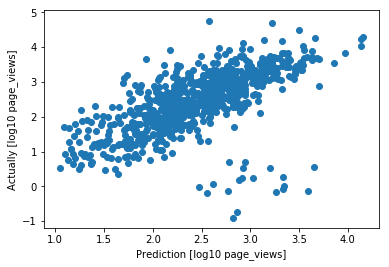

In [196]:
reg = linear_model.LinearRegression()

metrics = ['wikilink_count', 'wikifile_count', 'log10_word_count', 'external_link_count', 
           'log_wiki_link_count', 'talk_link_count','wikipeida_count']

reg.fit(X=train_data[metrics], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[metrics])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

## Does an increase in page size cause an increase in page viewership?

In [101]:
combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)

resampled_data = combined_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('1d').mean()

# remove data that is mostly na

pages = [page for page, df in resampled_data.groupby('page_title') if df.character_count.isna().sum()>1100]

resampled_data = resampled_data.drop(pages, level=0)

# calculate std of values of interest
resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)
std_data = resampled_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').std()


resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)
resampled_data = resampled_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').mean()


resampled_data.reset_index(inplace=True)
resampled_data.set_index(['page_title', 'timestamp'], inplace=True)

resampled_data['page_views_std'] = std_data['page_views']

resampled_data.reset_index(inplace=True)

resampled_data.set_index('timestamp', inplace=True)
resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())



In [103]:
resampled_data.reset_index(inplace=True)

In [104]:
resampled_data['word_count_delta'] = resampled_data.groupby('page_title')['word_count'].diff()
resampled_data['page_views_delta'] = resampled_data.groupby('page_title')['page_views'].diff()

In [106]:
resampled_data.dropna(inplace=True)

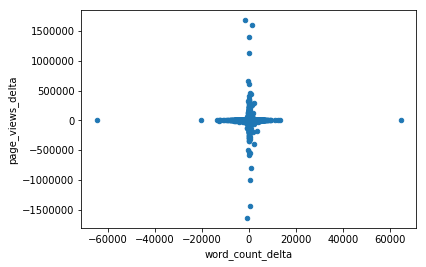

In [107]:
resampled_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter')

(-1000, 1000)

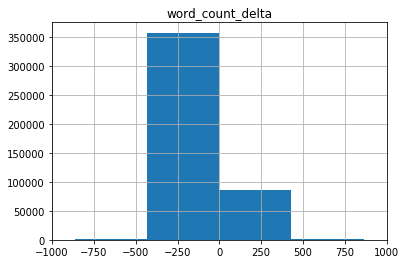

In [120]:
fig, ax = plt.subplots()
resampled_data.hist(column='word_count_delta', bins=300, ax=ax)
ax.set_xlim(-1000, 1000)

In [124]:
resampled_data = resampled_data[(resampled_data.word_count_delta < 750) &
                                (resampled_data.word_count_delta > -750) &
                                (resampled_data.page_views_delta < )]

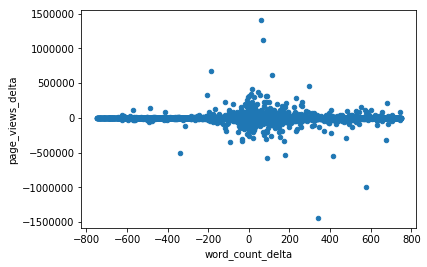

In [134]:
resampled_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter')

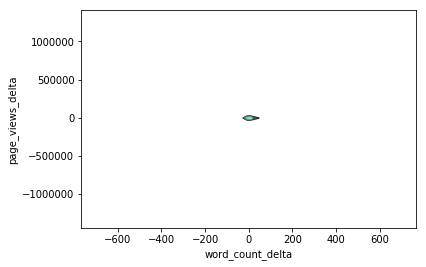

In [135]:
sns.kdeplot(data=resampled_data.word_count_delta, data2=resampled_data.page_views_delta )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7D645C978>],
      dtype=object)

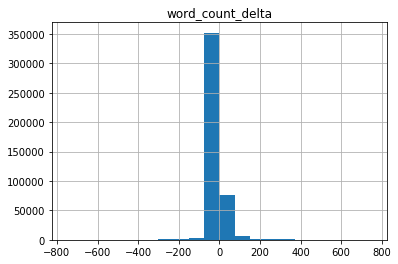

In [127]:
fig, ax = plt.subplots()
resampled_data.hist(column='word_count_delta', bins=20, ax=ax)
# ax.set_xlim(-1000, 1000)

(-250, 250)

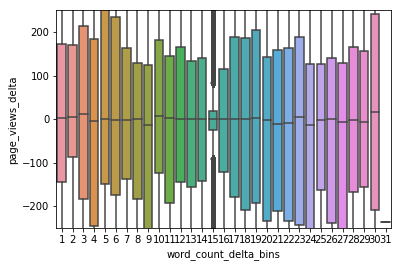

In [133]:
_, bins = np.histogram(resampled_data.word_count_delta, bins=30)
resampled_data['word_count_delta_bins'] = np.digitize(resampled_data.word_count_delta, bins=bins)

fig, ax = plt.subplots()

sns.boxplot(x='word_count_delta_bins', y='page_views_delta', data=resampled_data, ax = ax)
ax.set_ylim(-250, 250)

In [ ]:
resampled_data.word_count_delta

KeyboardInterrupt: 

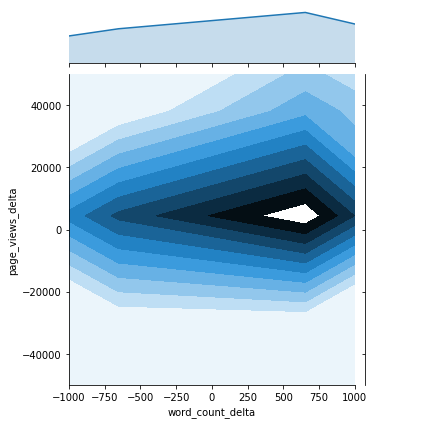

In [109]:
sns.jointplot(x=resampled_data.word_count_delta, y=resampled_data.page_views_delta, kind='kde', xlim=(-1000, 1000),
              ylim=(-50000, 50000) );


In [311]:
# resampled_data.reset_index(inplace=True)
reindexed_data = resampled_data.copy()
reindexed_data.timestamp = reindexed_data.timestamp + pd.to_timedelta(10, unit='D')

In [312]:
resampled_data.set_index(['page_title', 'timestamp'], inplace=True)

In [313]:
reindexed_data.set_index(['page_title', 'timestamp'], inplace=True)

In [314]:
reindexed_data = reindexed_data[['page_views', 'page_views_delta', 'word_count', 'word_count_delta']]
reindexed_data.columns = ['last_week_page_views', 'last_week_page_views_delta',  
                          'last_week_word_count', 'last_week_word_count_delta']

In [315]:
last_week_trends_data = pd.concat([resampled_data, reindexed_data], axis=1)

In [316]:
last_week_trends_data.dropna(inplace=True)

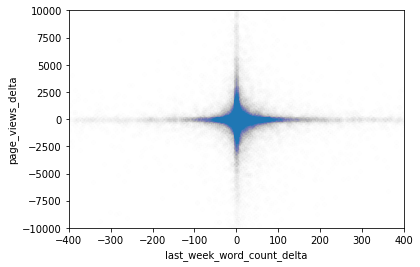

In [317]:
last_week_trends_data.plot(x='last_week_word_count_delta', y='page_views_delta', kind='scatter', alpha=0.005,
                          xlim=(-400, 400), ylim=(-10000, 10000))

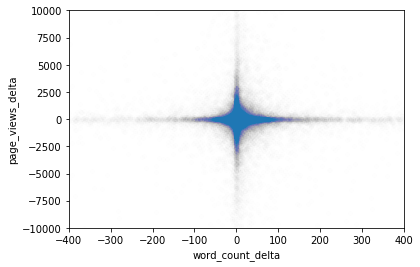

In [318]:
last_week_trends_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter', alpha=0.005,
                          xlim=(-400, 400), ylim=(-10000, 10000))

In [319]:
# sns.jointplot(x=last_week_trends_data.last_week_word_count_delta, y=last_week_trends_data.page_views_delta, 
#               kind='kde', xlim=(-400, 400), ylim=(-20000, 20000));


In [320]:
# sns.jointplot(x=last_week_trends_data.word_count_delta, y=last_week_trends_data.page_views_delta, kind='kde', 
#               xlim=(-400, 400), ylim=(20000, -20000));

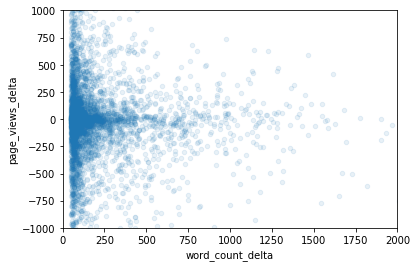

In [328]:
last_week_trends_data[last_week_trends_data.word_count_delta > 50].plot(x='word_count_delta', 
                                                                        y='page_views_delta', 
                                                                        kind='scatter', alpha=0.1, 
                                                                        xlim=(0, 2000), ylim=(-1000, 1000))

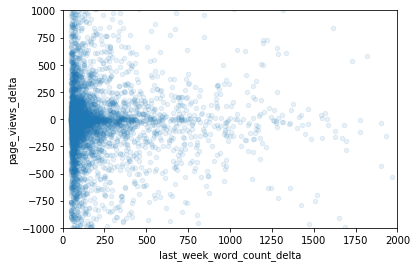

In [330]:
last_week_trends_data[last_week_trends_data.last_week_word_count_delta > 50].plot(x='last_week_word_count_delta', 
                                                                        y='page_views_delta', 
                                                                        kind='scatter', alpha=0.1, 
                                                                        xlim=(0, 2000), ylim=(-1000, 1000))

In [335]:
len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50) &
                      (last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50)])

0.43242753623188407

In [336]:
len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50) &
                          -(last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50)])

0.567572463768116

In [337]:
len(last_week_trends_data[(last_week_trends_data.word_count_delta > 50) &
                          (last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.word_count_delta > 50)])

0.46946216955332726

In [178]:
pd.concat([resampled_data, reindexed_data])

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,external_link_count,heading_count,index,last_week_page_views,last_week_page_views_delta,page_views,page_views_delta,page_views_std,wikifile_count,wikilink_count,word_count,word_count_delta
timestamp,,,,,,,,,,,,
2015-07-31,10.000000,4.0,1.0,NaN,NaN,13.375000,-2.261364,5.314314,19.531250,0.0,477.593750,1.593750
2015-08-30,10.000000,4.0,2.0,NaN,NaN,15.566667,2.191667,5.399127,20.000000,0.0,479.000000,1.406250
2015-09-29,10.000000,4.0,3.0,NaN,NaN,12.700000,-2.866667,4.579941,20.000000,0.0,479.000000,0.000000
2015-10-29,10.000000,4.0,4.0,NaN,NaN,15.833333,3.133333,5.843259,20.000000,0.0,479.000000,0.000000
2015-11-28,10.176471,4.0,5.0,NaN,NaN,15.882353,0.049020,5.623353,19.852941,0.0,479.411765,0.411765
2015-12-28,12.000000,4.0,6.0,NaN,NaN,13.533333,-2.349020,4.576803,19.000000,0.0,483.000000,3.588235
2016-01-27,12.000000,4.0,7.0,NaN,NaN,14.709677,1.176344,5.556939,20.806452,0.0,483.903226,0.903226
2016-02-26,12.000000,4.0,8.0,NaN,NaN,14.000000,-0.709677,4.417832,23.000000,0.0,485.000000,1.096774
2016-03-27,12.000000,4.0,9.0,NaN,NaN,12.666667,-1.333333,4.002873,23.000000,0.0,485.000000,0.000000


In [170]:
combined_data.dropna()

,,external_link_count,heading_count,index,last_week_page_views,last_week_page_views_delta,page_views,page_views_delta,page_views_std,wikifile_count,wikilink_count,word_count,word_count_delta
page_title,timestamp,,,,,,,,,,,,


In [59]:
for page, df in resampled_data.groupby('page_title'):
    

,page_title,timestamp,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
1,032c,2015-07-08,10.000000,4.000000,21.000000,19.000000,0.0,476.000000
2,032c,2015-07-15,10.000000,4.000000,11.714286,19.000000,0.0,476.000000
3,032c,2015-07-22,10.000000,4.000000,14.857143,19.000000,0.0,476.000000
4,032c,2015-07-29,10.000000,4.000000,13.714286,19.000000,0.0,476.000000
5,032c,2015-08-05,10.000000,4.000000,10.285714,19.000000,0.0,476.000000
6,032c,2015-08-12,10.000000,4.000000,15.888889,19.666667,0.0,478.000000
7,032c,2015-08-19,10.000000,4.000000,12.428571,20.000000,0.0,479.000000
8,032c,2015-08-26,10.000000,4.000000,15.571429,20.000000,0.0,479.000000
9,032c,2015-09-02,10.000000,4.000000,16.428571,20.000000,0.0,479.000000
10,032c,2015-09-09,10.000000,4.000000,17.285714,20.000000,0.0,479.000000


In [ ]:
standard_deviation = combined_data[['page_views', 'page_title']].groupby('page_title').resample('1w').std()

In [243]:
resampled_data.dropna(inplace=True)

In [244]:
resampled_data

,page_title,timestamp,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
1,032c,2015-07-12,10.000000,4.000000,20.900000,19.000000,0.0,476.000000
2,032c,2015-07-19,10.000000,4.000000,11.428571,19.000000,0.0,476.000000
3,032c,2015-07-26,10.000000,4.000000,14.428571,19.000000,0.0,476.000000
4,032c,2015-08-02,10.000000,4.000000,16.142857,19.000000,0.0,476.000000
5,032c,2015-08-09,10.000000,4.000000,10.000000,19.000000,0.0,476.000000
6,032c,2015-08-16,10.000000,4.000000,15.555556,19.444444,0.0,477.333333
7,032c,2015-08-23,10.000000,4.000000,11.428571,20.000000,0.0,479.000000
8,032c,2015-08-30,10.000000,4.000000,16.285714,20.000000,0.0,479.000000
9,032c,2015-09-06,10.000000,4.000000,15.714286,20.000000,0.0,479.000000
10,032c,2015-09-13,10.000000,4.000000,14.571429,20.000000,0.0,479.000000


## processing revision history 

We are going to make no attempt to filter the kind of revsions. Instead we are just going to look at the data that can be easily processed

## Stacking data on top of eachother

I want to combine pageview and revisions into one dataframe


In [66]:
filled_indexed_data = indexed_combined_data.fillna(method='ffill')

In [67]:
resampled_data = filled_indexed_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').mean()

In [68]:
combined_data = pd.concat([revisions, resampled_data], axis=1)

# Plotting the data

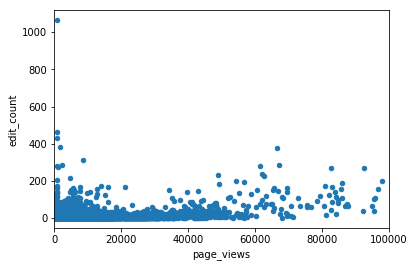

In [69]:
combined_data.plot(x='page_views', y='edit_count', kind='scatter', xlim=[0,100000])

In [70]:
# data_to_plot = combined_data[(combined_data.page_views < 10000) &
#                              (combined_data.edit_count < 200)]

# f, ax = plt.subplots(figsize=(6, 6))


# sns.kdeplot(data_to_plot.page_views, data_to_plot.edit_count, ax=ax)

# ax.set_ylim(0, 20)
# ax.set_xlim(0, 1000)

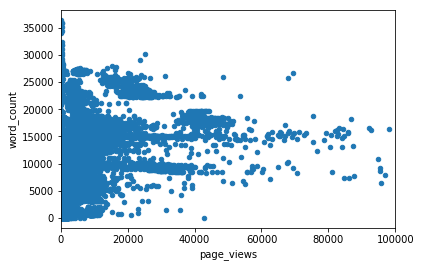

In [71]:
combined_data.plot(x='page_views', y='word_count', kind='scatter', xlim=[0,100000])

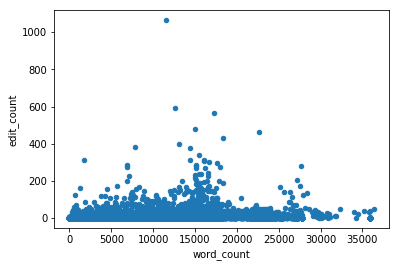

In [72]:
combined_data.plot(y='edit_count', x='word_count', kind='scatter')

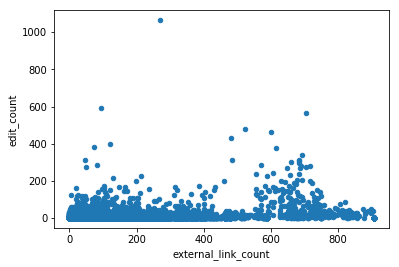

In [73]:
combined_data.plot(y='edit_count', x='external_link_count', kind='scatter')

Page views are all over the place. I need to establish some kind of moving window of pageviews, like a monthly average.

In [74]:
combined_data.reset_index(inplace=True)

In [75]:
combined_data = combined_data.set_index('timestamp')

In [78]:
sixtyone_days_pageviews = combined_data.groupby('page_title').page_views.rolling('70d').mean().to_frame('70d_averge_pageviews')

In [85]:
combined_data = combined_data.reset_index().set_index(['page_title', 'timestamp'])

In [87]:
combined_data = pd.concat([combined_data, sixtyone_days_pageviews], axis=1, join='inner')

In [89]:
combined_data['normalized_page_views'] = combined_data.page_views/combined_data['70d_averge_pageviews']

In [90]:
combined_data

edit_count  character_count  \
page_title              timestamp                                 
12 Years a Slave (film) 2015-07-01           6     32777.000000   
                        2015-07-08           2     32853.777778   
                        2015-07-15           8     32847.533333   
                        2015-07-22           2     32887.222222   
                        2015-07-29           5     32866.250000   
                        2015-08-05           1     32867.000000   
                        2015-08-12           1     32867.000000   
                        2015-08-19           4     32870.727273   
                        2015-08-26           5     32867.000000   
                        2015-09-02           3     32843.000000   
                        2015-09-09           0     32819.000000   
                        2015-09-16           0     32819.000000   
                        2015-09-23           1     32838.500000   
                        2015-09-30           3     32885.200000   
                        2015-10-07           3     32892.000000   
                        2015-10-14           0     32892.000000   
                        2015-10-21           0     32892.000000   
                        2015-10-28           6     32891.538462   
                        2015-11-04           0     32892.000000   
                        2015-11-11           7     33143.785714   
                        2015-11-18           5     33005.583333   
                        2015-11-25           0     32990.000000   
                        2015-12-02           7     33012.000000   
                        2015-12-09          17     31766.875000   
                        2015-12-16           2     30233.222222   
                        2015-12-23           1     30240.000000   
                        2015-12-30           7     30237.142857   
                        2016-01-06           6     30519.153846   
                        2016-01-13           4     31126.363636   
                        2016-01-20           2     31120.888889   
...                                        ...              ...   
war                     2017-12-06           2     51515.111111   
                        2017-12-13           0     51371.000000   
                        2017-12-20           3     51362.000000   
                        2017-12-27           0     51343.000000   
                        2018-01-03           2     51343.000000   
                        2018-01-10           0     51343.000000   
                        2018-01-17           0     51343.000000   
                        2018-01-24           0     51343.000000   
                        2018-01-31           0     51343.000000   
                        2018-02-07           1     51343.000000   
                        2018-02-14           2     51343.000000   
                        2018-02-21           0     51343.000000   
                        2018-02-28           1     51344.875000   
                        2018-03-07           0     51358.000000   
                        2018-03-14           0     51358.000000   
                        2018-03-21           1     51358.000000   
                        2018-03-28           0     51358.000000   
                        2018-04-04           1     51358.000000   
                        2018-04-11           0     51358.000000   
                        2018-04-18           3     51360.100000   
                        2018-04-25           1     51363.000000   
                        2018-05-02           0     51363.000000   
                        2018-05-09           4     51182.363636   
                        2018-05-16           2     50855.000000   
                        2018-05-23           0     50855.000000   
                        2018-05-30           0     50855.000000   
                        2018-06-06           0     50855.000000   
                

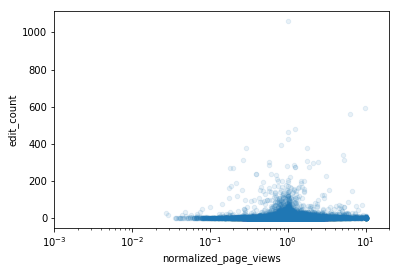

In [99]:
combined_data.plot(x='normalized_page_views', y='edit_count', kind='scatter', logx=True, xlim=[0.001, 20],
                     alpha=0.1)

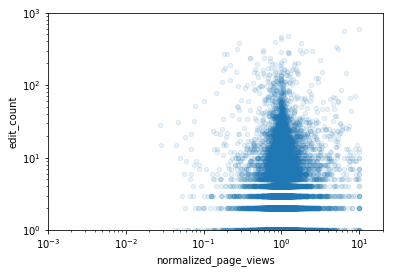

In [114]:
combined_data.plot(x='normalized_page_views', y='edit_count', kind='scatter', logx=True, logy=True, xlim=[0.001, 20],
                   ylim=[1, 1000],
                     alpha=0.1)

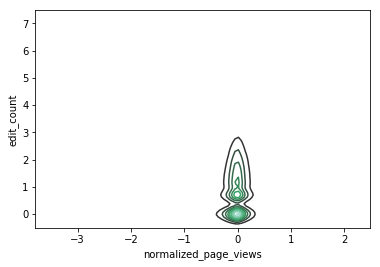

In [121]:
data_to_plot = combined_data[(combined_data.normalized_page_views != 0) &
                             (combined_data.edit_count != 0) &
                             (-combined_data.edit_count.isna()) &
                             (-combined_data.normalized_page_views.isna())]

sns.kdeplot(np.log(data_to_plot.normalized_page_views), np.log(data_to_plot.edit_count))

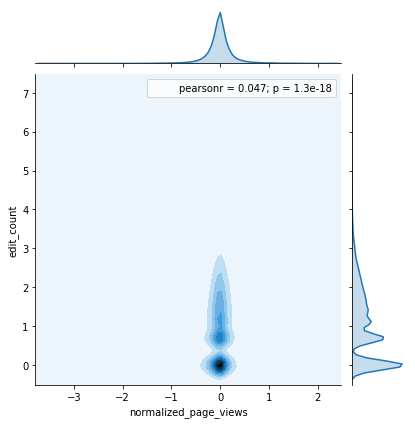

In [122]:
sns.jointplot(x=np.log(data_to_plot.normalized_page_views), y= np.log(data_to_plot.edit_count), kind="kde")

In [128]:
len(set(data_to_plot.index.get_level_values(0)))

692

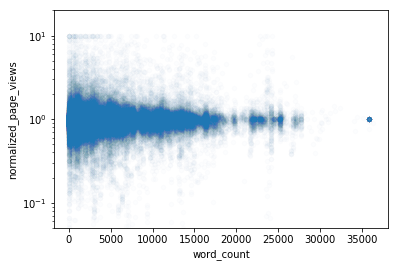

In [132]:
combined_data.plot(x='word_count', y='normalized_page_views', kind='scatter',alpha=0.01, 
                    logy=True, ylim=[0.05, 20],)

The above plot implies that large wikipedias have less varience in viewership. This would make sense especially if large wikpedias have signficantly more viewership.

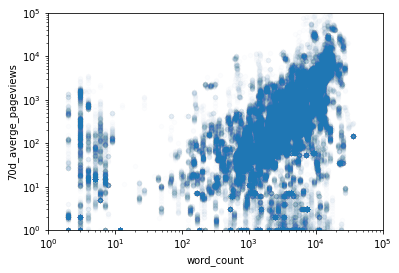

In [112]:
combined_data.plot(x='word_count', y='70d_averge_pageviews', kind='scatter', logy=True, logx=True, ylim=[1, 100000], 
                   xlim=[1, 100000], alpha=0.01)

Indeed there seems to be a trend between the size of a wikipedia article (number of words it contains) and the average pageviews.

# quick look at rates of growth

I'm going to quickly try to identify if these metrics coorelate to the rate of growth of a wikipedia page

In [134]:
combined_data = combined_data.reset_index()

In [135]:
combined_data

,page_title,timestamp,edit_count,character_count,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count,70d_averge_pageviews,normalized_page_views
0,12 Years a Slave (film),2015-07-01,6,32777.000000,93.833333,18.000000,4060.615385,291.333333,6.0,5307.333333,4060.615385,1.000000
1,12 Years a Slave (film),2015-07-08,2,32853.777778,94.000000,18.000000,4346.111111,291.000000,6.0,5321.888889,4203.363248,1.033960
2,12 Years a Slave (film),2015-07-15,8,32847.533333,94.000000,18.000000,4705.333333,291.133333,6.0,5321.133333,4370.686610,1.076566
3,12 Years a Slave (film),2015-07-22,2,32887.222222,94.000000,18.000000,4630.555556,289.888889,6.0,5330.666667,4435.653846,1.043940
4,12 Years a Slave (film),2015-07-29,5,32866.250000,94.000000,18.000000,4046.916667,289.083333,6.0,5328.916667,4357.906410,0.928638
5,12 Years a Slave (film),2015-08-05,1,32867.000000,94.000000,18.000000,3837.500000,289.000000,6.0,5329.000000,4271.172009,0.898465
6,12 Years a Slave (film),2015-08-12,1,32867.000000,94.000000,18.000000,4010.750000,289.000000,6.0,5329.000000,4233.968864,0.947279
7,12 Years a Slave (film),2015-08-19,4,32870.727273,94.000000,18.000000,4004.727273,289.090909,6.0,5329.454545,4205.313666,0.952302
8,12 Years a Slave (film),2015-08-26,5,32867.000000,94.000000,18.000000,4043.166667,289.000000,6.0,5329.000000,4187.297332,0.965579
9,12 Years a Slave (film),2015-09-02,3,32843.000000,94.000000,18.000000,3771.800000,289.000000,6.0,5325.000000,4145.747599,0.909800


In [139]:
combined_data.groupby('page_title').apply(lambda x: pd.Series(np.gradient(x.word_count), 
                                                                         x.timestamp, name='slope'))



timestamp,2015-07-01 00:00:00,2015-07-08 00:00:00,2015-07-15 00:00:00,2015-07-22 00:00:00,2015-07-29 00:00:00,2015-08-05 00:00:00,2015-08-12 00:00:00,2015-08-19 00:00:00,2015-08-26 00:00:00,2015-09-02 00:00:00,...,2018-04-25 00:00:00,2018-05-02 00:00:00,2018-05-09 00:00:00,2018-05-16 00:00:00,2018-05-23 00:00:00,2018-05-30 00:00:00,2018-06-06 00:00:00,2018-06-13 00:00:00,2018-06-20 00:00:00,2018-06-27 00:00:00
page_title,,,,,,,,,,,,,,,,,,,,,
12 Years a Slave (film),14.555556,6.900000,4.388889,3.891667,-0.833333,0.041667,0.227273,0.000000,-2.227273,-4.000000,...,-3.438725,17.343750,0.465241,3.000000,4.056818,0.500000,-0.375000,-2.500000,-18.000000,-31.000000
1804 Haiti massacre,-3238.900000,-1800.000000,-124.550000,150.205882,69.681818,-27.705882,-3.181818,0.000000,5.444444,25.472222,...,0.000000,0.000000,0.133333,0.000000,2.787719,3.500000,0.578947,1.444444,0.000000,-2.888889
1862 congressional elections,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-124.187500,-993.500000,-869.312500,0.000000,0.000000,0.000000,0.000000
3M,2020.666667,1010.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.500000,...,0.000000,4.950000,50.000000,48.550000,3.181818,-3.500000,-3.181818,0.000000,0.000000,0.000000
3M Performance 400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-518.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3M Separation and Purification Solutions,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3M bookshelf game series,0.000000,0.000000,0.000000,0.000000,175.437500,200.500000,25.062500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"75,000 volunteers",-113.750000,-56.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Abraham Lincoln,3246.600000,1623.300000,0.000000,0.000000,0.000000,0.150000,-0.150000,11.450000,25.111538,11.900000,...,29.940559,14.136364,8.269697,272.663636,1.922222,-262.168421,5.555556,4.118421,7.888889,2.500000


In [142]:
np.gradient(combined_data[combined_data.page_title == '12 Years a Slave (film)'].word_count)

array([ 1.45555556e+01,  6.90000000e+00,  4.38888889e+00,  3.89166667e+00,
       -8.33333333e-01,  4.16666667e-02,  2.27272727e-01,  0.00000000e+00,
       -2.22727273e+00, -4.00000000e+00, -2.00000000e+00,  1.00000000e+00,
        4.00000000e+00,  3.50000000e+00,  5.00000000e-01,  0.00000000e+00,
       -3.84615385e-02,  0.00000000e+00,  2.02884615e+01,  8.12500000e+00,
       -1.32500000e+01, -5.35714286e-02, -1.00062500e+02, -2.26404762e+02,
       -1.24937500e+02,  2.26190476e-01,  2.38076923e+01,  7.27435065e+01,
        4.86923077e+01, -1.36363636e-01,  0.00000000e+00, -1.13636364e-01,
        2.22222222e-01, -3.34801136e+01, -8.88888889e+00,  2.50937500e+01,
        1.66666667e-01,  0.00000000e+00,  4.64285714e-01, -2.94117647e-01,
       -7.14285714e-01,  1.73856209e+00,  2.50000000e-01, -1.94444444e+00,
       -5.00000000e-01,  3.18181818e+00,  5.00000000e+00,  1.81818182e+00,
        5.55555556e-02,  0.00000000e+00,  3.78582375e+01,  4.86153846e+01,
        1.37920892e+01,  

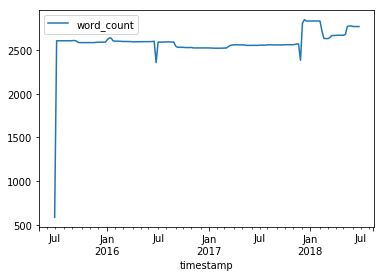

In [149]:
combined_data[combined_data.page_title == '3M'].plot(x='timestamp', y='word_count')

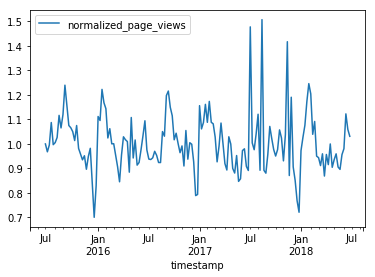

In [150]:
combined_data[combined_data.page_title == '3M'].plot(x='timestamp', y='normalized_page_views')

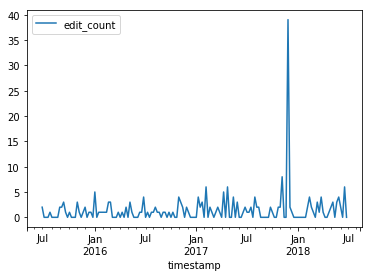

In [151]:
combined_data[combined_data.page_title == '3M'].plot(x='timestamp', y='edit_count')